In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013

 99% 60.0M/60.3M [00:02<00:00, 28.2MB/s]
100% 60.3M/60.3M [00:02<00:00, 21.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf     #primary deep learning library
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for augmentation and image loading
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
import os
import cv2

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
category_list=os.listdir(r"/content/train")

Visualizing category :  neutral --------------------------------------
/content/train/neutral/Training_57173041.jpg
Visualizing category :  disgust --------------------------------------
/content/train/disgust/Training_20847777.jpg
Visualizing category :  fear --------------------------------------
/content/train/fear/Training_55143341.jpg
Visualizing category :  sad --------------------------------------
/content/train/sad/Training_4610921.jpg
Visualizing category :  angry --------------------------------------
/content/train/angry/Training_32440149.jpg
Visualizing category :  happy --------------------------------------
/content/train/happy/Training_66417078.jpg
Visualizing category :  surprise --------------------------------------
/content/train/surprise/Training_96287206.jpg


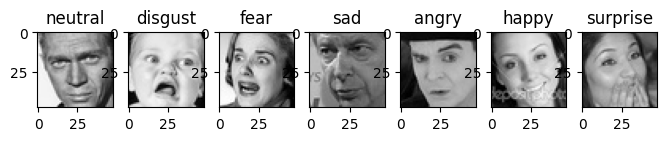

In [ ]:
#picking one image from every class in training and visualizing it in a row side by side by using title to display img with label
train_base_dir="/content/train"
fig=plt.figure(figsize=(8,8))
i=1
for category in category_list:
    print("Visualizing category : ",category,"--------------------------------------")
    category_path=os.path.join(train_base_dir,category)
    flag=False
    for img_name in os.listdir(category_path):
        if(flag):
            break
#         print(os.path.join(category_path,img_name))
        img_path=os.path.join(category_path,img_name)
        img_bgr=cv2.imread(img_path)
        print(img_path)
        img_rgb=cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
#         print(i)
        plt.subplot(1,7,i)
        plt.imshow(img_rgb)
        plt.title(category)
        flag=True
        i=i+1
plt.show() # display the result

In [ ]:
#creating the imagedatagenerator, used to read and augment images
train_data_gen=ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1./255)

In [ ]:
test_data_gen=ImageDataGenerator(rescale=1./255)

In [ ]:
#taking batches of images out of folder -> no burden on ram and cpu plus easier
train_data=train_data_gen.flow_from_directory(
    directory=train_base_dir,
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32
)

Found 28709 images belonging to 7 classes.


In [ ]:
train_data

In [ ]:
test_data=test_data_gen.flow_from_directory(
    directory="/content/test",
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
)

Found 7178 images belonging to 7 classes.


In [ ]:
class_indices = train_data.class_indices
category_mapping = {v: k for k, v in class_indices.items()}
# {0: 'angry',
#  1: 'disgust',
#  2: 'fear',
#  3: 'happy',
#  4: 'neutral',
#  5: 'sad',
#  6: 'surprise'}

In [ ]:
category_mapping

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [ ]:
model=tf.keras.applications.MobileNetV3Large()

22661472/22661472 [==============================] - 0s 0us/step


In [ ]:
# display model summary
model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
#adding some ANN layers at last
output=model.layers[-1].output
output=BatchNormalization()(output)
output=Dense(128)(output)
output=BatchNormalization()(output)
# output=Dense(64,activation="relu")(output)
output=Dense(7,activation="softmax")(output)

In [ ]:
#saving new_model
new_model=tf.keras.Model(inputs=model.input, outputs=output)

In [ ]:
# fine tuning needs smaller learning rates !!
from keras.optimizers import Adam
adam=Adam(learning_rate=0.0001)

In [ ]:
#compiling the model
new_model.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
#used to stop early if no improvement on test/validation data-> prevent overfitting
earlystop=EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='min',
    restore_best_weights=True,
)

#reducing lear
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
history=new_model.fit(
    train_data,
    epochs=10,
    callbacks=[earlystop,reduce_lr],
    validation_data=test_data
)

Epoch 1/10
898/898 [==============================] - 437s 443ms/step - loss: 1.4972 - accuracy: 0.4451 - val_loss: 2.2071 - val_accuracy: 0.1771 - lr: 1.0000e-04
Epoch 2/10
898/898 [==============================] - 392s 437ms/step - loss: 1.1549 - accuracy: 0.5733 - val_loss: 2.0892 - val_accuracy: 0.1872 - lr: 1.0000e-04
Epoch 3/10
898/898 [==============================] - 390s 434ms/step - loss: 1.0443 - accuracy: 0.6099 - val_loss: 1.8064 - val_accuracy: 0.2870 - lr: 1.0000e-04
Epoch 4/10
898/898 [==============================] - 388s 432ms/step - loss: 0.9669 - accuracy: 0.6403 - val_loss: 2.2590 - val_accuracy: 0.2017 - lr: 1.0000e-04
Epoch 5/10
898/898 [==============================] - 389s 433ms/step - loss: 0.9172 - accuracy: 0.6611 - val_loss: 1.3545 - val_accuracy: 0.4923 - lr: 1.0000e-04
Epoch 6/10
898/898 [==============================] - 393s 438ms/step - loss: 0.8605 - accuracy: 0.6817 - val_loss: 1.5080 - val_accuracy: 0.4653 - lr: 1.0000e-04
Epoch 7/10
898/898 [==

In [ ]:
new_model.save('my_model.h5')

In [ ]:
import pickle
# Define the file path
file_path = 'category_map.pkl'

# Write the dictionary to a file using pickle
with open(file_path, 'wb') as f:
    pickle.dump(category_mapping, f)

print("Dictionary exported to", file_path)

Dictionary exported to category_map.pkl


In [ ]:
import cv2
import numpy as np
import tensorflow
import warnings
warnings.filterwarnings('ignore')
import pickle
# Define the file path
file_path = 'category_map.pkl'

# Read the dictionary from the file using pickle
with open(file_path, 'rb') as f:
    my_dict = pickle.load(f)

print("Dictionary imported successfully:", my_dict)
model=tensorflow.keras.models.load_model("my_model.h5")
cap=cv2.VideoCapture(0)
while(True):
    ret,frame=cap.read()
    facecascade=cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=facecascade.detectMultiScale(gray)
    for x,y,w,h in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color=frame[y:y+h,x:x+w]
        roi_color_resized=cv2.resize(roi_color,(224,224))
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),3)
        final_img=np.expand_dims(roi_color_resized,axis=0)
        final_img=final_img/255.0
        index=np.argmax((model.predict(final_img)))
        cv2.putText( img = frame,text = my_dict[index],org = (x-20,y-20),fontFace = cv2.FONT_HERSHEY_DUPLEX,
                    fontScale = 1.0,color = (125, 246, 55),thickness = 3)
    cv2.imshow("window",frame)
    if cv2.waitKey(2) & 0xFF==ord("q"):
        break;
cap.release()
cv2.destroyAllWindows()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

In [ ]:
roi_color = cv2.imread("/content/photo.jpg")
roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)

In [ ]:
roi_color_resized = cv2.resize(roi_color, (224, 224))
final_img = np.expand_dims(roi_color_resized, axis=0)
final_img = final_img / 255.0
predicted = model.predict(final_img)
index = np.argmax(predicted)
emotion = emotion_dict[index]

1/1 [==============================] - 0s 65ms/step


In [ ]:
emotion

'sad'